# Modelo Transformer

En este notebook están los pasos para generar modelos Transformer para tratar de solucionar el problema de predicción de colores.

En este caso he usado la **librería Pytorch** para aprender un poco más de ella.

Recordamos con una gráfica el modelo Transformer:

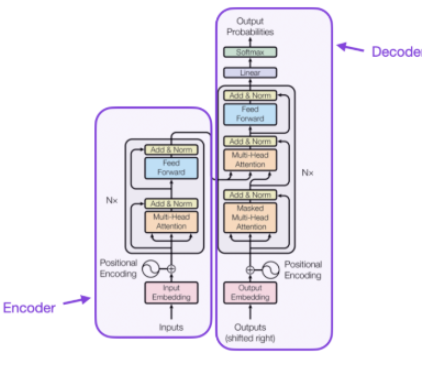

En mi caso solo voy a crear el **encoder**, no necesito el **decoder** porque:

* No estoy generando una secuencia como salida.
* Solo necesito que el encoder procese la secuencia de entrada y produzca una representación rica para predecir los 3 valores finales (L, A, B).

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import product
import copy
from typing import NamedTuple, Dict, Any, List
import math

# Variables globales

In [2]:
# 📂 Archivos de entrada y salida
FIC_ENTRADA = 'train_test_val_scaler.joblib'  # Archivo de datos escalados de entrenamiento, validación y test
RUTA_FICHEROS = r"C:\Users\jaume\Documents\Proyecto\datos"  # Ruta donde se almacenan los archivos de datos
FIC_SALIDA = 'prediccion_transformers.joblib'  # Archivo donde se guardarán las predicciones del modelo

NUM_WORKERS = 0 # Procesos en  paralelo que se utilizan para cargar y preprocesar los datos. (0 -> Default no paralelo)
# Semilla aleatoria
SEED = 7419

# 📊 Parámetros para la división de datos y procesamiento por lotes
WINDOW_SIZE = 30  # Tamaño de la ventana de entrada para el modelo (número de pasos de tiempo usados como input)
OFFSET = 4  # Número de pasos hacia adelante para predecir
BATCH_SIZE = 128  # Tamaño de cada batch en el entrenamiento

# ⚙️ Hiperparámetros del modelo y entrenamiento
ADAM_LR = 1e-5  # Tasa de aprendizaje para el optimizador Adam
EPOCHS = 100  # Número máximo de épocas para entrenar el modelo
PATIENCE = 6  # Número de épocas sin mejora antes de detener el entrenamiento (Early Stopping)
WEIGHT_DECAY = 1e-4  # Para prevenir el overfitting
MIN_DELTA = 0.01  # Evita que continuar el entrenamiento cuando las mejoras son insignificantes

# Mirar si pytorch usará GPU


In [3]:
# 1) Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

Dispositivo utilizado: cuda


# Semillas de aleatoriedad

Para que sea lo más reproducible posible. Aunque ciertas cosas como el **dropout** pueden afectar al resultado

In [4]:
# Establecer la variable de entorno para CuBLAS (debe hacerse antes de importar torch)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Fijar la semilla en Python, NumPy y PyTorch
#random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Si se dispone de GPU, fijar también la semilla para CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Forzar operaciones deterministas en cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# (Opcional) Fijar la semilla del hash de Python
os.environ["PYTHONHASHSEED"] = str(SEED)

# Desde PyTorch 1.8, se puede forzar el uso de algoritmos determinísticos:
torch.use_deterministic_algorithms(True)

print("Semilla fijada y operaciones deterministas activadas para PyTorch.")

Semilla fijada y operaciones deterministas activadas para PyTorch.


# Carga de datos

In [5]:
# Carga de datos
os.chdir(RUTA_FICHEROS)

with open(FIC_ENTRADA, 'rb') as file:
    data_dict = joblib.load(file)

# Recuperar DataFrame y scaler
df_train = data_dict['train'].copy()
df_test = data_dict['test'].copy()
df_val = data_dict['val'].copy()
#scaler = data_dict['scaler']              # No me hace falta aquí

C:\Users\jaume\anaconda3\envs\pytorch_GPU_NLP_Ricard\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Clase `LABDataset` para Secuencias Temporales en PyTorch

Este código define la clase `LABDataset` para preparar un dataset secuencial adecuado para modelos que procesan series temporales, como RNNs o Transformers. Cada muestra consta de una secuencia de características (`features`) de longitud `sequence_length` y un objetivo (`targets`) desplazado por un `offset`. El método `__getitem__` devuelve la secuencia de entrada (`x_seq`) y el valor objetivo (`y_lab`) en forma de tensores.

**📄 Descripción**
Esta clase define un **dataset en PyTorch (`LABDataset`)** diseñado para manejar **secuencias temporales** en tareas de aprendizaje profundo.  

✅ **Características clave:**  
- **Extrae secuencias de tamaño `sequence_length`** como entrada (`X`).  
- **Genera etiquetas (`Y`) desplazadas `offset` pasos hacia adelante** para predicción.  
- **Compatible con `torch.utils.data.Dataset`**, lo que permite el uso con `DataLoader`.  
- **Maneja múltiples variables de entrada y salida**, incluyendo `L_scaled`, `A_scaled` y `B_scaled`.  

📌 **¿Por qué es útil?**  
Esta clase facilita la preparación de **datos secuenciales** para modelos que requieren **contexto temporal**, evitando el procesamiento manual de ventanas de datos.

In [6]:
class LABDataset(Dataset):
    """
    Dataset para manejar secuencias temporales en PyTorch.
    
    Extrae ventanas de datos (`sequence_length`) y etiquetas (`offset`) 
    para entrenar modelos que procesan series temporales.
    
    Args:
        df (pd.DataFrame): DataFrame con los datos de entrada.
        sequence_length (int): Longitud de la secuencia de entrada.
        offset (int): Desplazamiento para la etiqueta futura.

    Returns:
        tuple: (x_seq_tensor, y_tensor) -> Entrada y salida como tensores de PyTorch.
    """
    
    def __init__(self, df, sequence_length=12, offset=4):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.sequence_length = sequence_length
        self.offset = offset
        
        # Definir columnas de entrada y salida
        self.feature_cols = [col for col in self.df.columns if col not in ['L_scaled', 'A_scaled', 'B_scaled']]
        self.target_cols = ['L_scaled', 'A_scaled', 'B_scaled']

        # Convertir a matrices numpy para eficiencia
        self.features = self.df[self.feature_cols].values
        self.targets = self.df[self.target_cols].values
        
        # Definir índices válidos
        self.first_valid_idx = self.sequence_length - 1
        self.last_valid_idx = len(self.df) - 1 - self.offset
        self._length = max(0, self.last_valid_idx - self.first_valid_idx + 1)

    def __len__(self):
        """ Devuelve el número total de secuencias disponibles en los datos. """
        return self._length

    def __getitem__(self, idx):
        """
        Extrae una secuencia de entrada y su respectiva etiqueta.

        Args:
            idx (int): Índice de la secuencia dentro del dataset.

        Returns:
            tuple: (x_seq_tensor, y_tensor)
        """
        real_idx = self.first_valid_idx + idx

        # Obtener la secuencia de entrada (X)
        start_idx = real_idx - (self.sequence_length - 1)
        end_idx = real_idx + 1  # No inclusivo
        x_seq = self.features[start_idx:end_idx]  # Shape: (sequence_length, n_features)

        # Obtener la etiqueta de salida (Y)
        y_idx = real_idx + self.offset
        y_lab = self.targets[y_idx]  # Shape: (3,)

        # Convertir a tensores de PyTorch
        x_seq_tensor = torch.tensor(x_seq, dtype=torch.float32)
        y_tensor = torch.tensor(y_lab, dtype=torch.float32)

        return x_seq_tensor, y_tensor


# Generación de Datasets y Loaders para Secuencias Temporales (PyTorch)


Se crean datasets de entrenamiento, validación y prueba usando la clase `LABDataset` y se cargan con `DataLoader` de PyTorch. Estos loaders dividen los datos en lotes (`batch_size`), sin mezclar el orden (`shuffle=False`), para garantizar la integridad de las secuencias temporales.

El módulo `DataLoader` de PyTorch es una herramienta para cargar datos de manera eficiente durante el entrenamiento y evaluación de modelos. Facilita el manejo de lotes (batches), barajado (shuffling), y multiprocesamiento para cargar datos en paralelo.

```python
torch.utils.data.DataLoader(
    dataset,          # Dataset que quieres cargar.
    batch_size=1,     # Tamaño del lote.
    shuffle=False,    # Si se deben mezclar los datos.
    sampler=None,     # Define un muestreador personalizado.
    batch_sampler=None,  # Define un muestreador para los lotes.
    num_workers=0,    # Número de subprocesos para cargar datos.
    collate_fn=None,  # Función para unir los datos en un lote.
    pin_memory=False, # Optimiza transferencias al GPU.
    drop_last=False,  # Si se descartan los lotes incompletos.
    timeout=0,        # Tiempo de espera para los workers.
    worker_init_fn=None,  # Inicialización personalizada de los workers.
    persistent_workers=False  # Mantener los workers vivos entre iteraciones.
)
```

# Clase `CodificacionPosicional`

En modelos como los Transformers, los datos se procesan como secuencias de tokens (como palabras, números o pasos temporales). Sin embargo:

* **Transformers** *no entienden el orden natural de los datos* porque no procesan la información de izquierda a derecha como las RNN (redes recurrentes).
* Para que el modelo pueda distinguir la posición de cada token en la secuencia (por ejemplo, "1º, 2º, 3º..."), se utiliza una codificación posicional.
La codificación posicional añade información sobre la posición de cada elemento en la secuencia usando valores basados en funciones matemáticas (seno y coseno).

## Por qué se usa `max_len` en lugar de calcular las posiciones al vuelo

* Eficiencia: En lugar de calcular las posiciones cada vez que entrenas el modelo, se precalcula una vez para ahorrar tiempo.
* Reutilización: Las posiciones precalculadas se pueden usar en cada paso del entrenamiento o inferencia.
* Flexibilidad: Si tienes datos de diferentes longitudes (por ejemplo, secuencias de 50 y 70 elementos), el modelo simplemente usa las codificaciones precalculadas para las posiciones necesarias.

## Por qué codificamos usando sinus y cosinus

En este [video se explica bien](https://youtu.be/xi94v_jl26U?t=581).

In [7]:
class CodificacionPosicional(nn.Module):
    """
    Clase que implementa la codificación posicional para secuencias.
    Agrega información posicional (seno y coseno) a las representaciones de entrada.
    """
    def __init__(self, d_model, max_len=5000):
        """
        Inicializa la codificación posicional.
        
        Args:
            d_model (int): Dimensión del espacio latente del modelo.
            max_len (int): Longitud máxima de la secuencia para la codificación posicional.
        """
        super().__init__()
        
        # Matriz para almacenar las codificaciones posicionales
        cod_pos = torch.zeros(max_len, d_model)
        
        # Genera las posiciones [0, 1, ..., max_len-1]
        posiciones = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Factor de escala para las frecuencias seno y coseno
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        # Codificación seno para dimensiones pares y coseno para impares
        cod_pos[:, 0::2] = torch.sin(posiciones * div_term)
        cod_pos[:, 1::2] = torch.cos(posiciones * div_term)
        
        # Registra las codificaciones como un buffer no entrenable
        self.register_buffer('cod_pos', cod_pos)  # cod_pos: [max_len, d_model]

    def forward(self, x):
        """
        Agrega la codificación posicional a la entrada.
        
        Args:
            x (torch.Tensor): Tensor de entrada con forma [batch_size, seq_len, d_model].
        
        Returns:
            torch.Tensor: Tensor con codificación posicional sumada, misma forma que `x`.
        """
        # Obtiene la longitud real de la secuencia
        seq_len = x.size(1)
        
        # Extrae las codificaciones para la longitud de la secuencia
        pos_slice = self.cod_pos[:seq_len, :]  # [seq_len, d_model]
        
        # Ajusta las dimensiones para que coincidan con el batch
        pos_slice = pos_slice.unsqueeze(0)  # [1, seq_len, d_model]
        
        # Suma las codificaciones posicionales a la entrada
        return x + pos_slice

# Callback para medir los tiempos

Mediré el tiempo de los entrenamientos.

In [8]:
class TimeHistory:
    """Clase para medir el tiempo de cada época en PyTorch."""
    def __init__(self):
        self.times = []

    def on_epoch_begin(self):
        """Marca el inicio de la época."""
        self.epoch_start_time = time.time()

    def on_epoch_end(self):
        """Registra el tiempo transcurrido en la época."""
        self.times.append(time.time() - self.epoch_start_time)

    def get_total_time(self):
        """Devuelve el tiempo total de entrenamiento."""
        return sum(self.times)


# Clase `TransformerRegressor` - Modelo de Regresión basado en Transformers

Esta clase define un modelo de **regresión basado en un Transformer Encoder** en PyTorch. Se utiliza para procesar secuencias temporales y predecir una salida de 3 valores.

**🔹 ¿Por qué solo el Encoder?**

📌 **Los Transformers clásicos tienen un `encoder-decoder`**, pero este modelo usa **solo el encoder**.  

🚀 **Motivo:**  
- En una tarea de **predicción de series temporales**, no estamos generando una secuencia de salida paso a paso (como en traducción automática).  
- **El Encoder es suficiente** para aprender las representaciones y extraer información del contexto pasado.  
- **Más eficiente**: Usar solo el Encoder **reduce la carga computacional** sin afectar el rendimiento.

📌 **¿Por qué no usar un Decoder?**  
- En **tareas de regresión**, el objetivo es producir una **única predicción final** (L, A, B) en lugar de una secuencia.  
- Un **Decoder** se usa en problemas donde **se necesita generar múltiples pasos de salida** (como traducción o predicción de series futuras).

---

**🔹 Explicación de `nn.Linear`**

```python
self.input_fc = nn.Linear(feature_dim, d_model)
```
📌 **¿Qué hace?**  
Convierte los datos de entrada de `feature_dim` a `d_model`, ajustando la dimensionalidad para que el Transformer pueda procesarlos correctamente.

📌 **¿Por qué es necesario?**  
- Los datos de entrada pueden tener muchas características (`feature_dim`), pero el Transformer **requiere una dimensión fija (`d_model`)** para operar eficientemente.  
- `nn.Linear` es una **transformación lineal** (`XW + b`) que permite proyectar los datos de entrada a un **espacio latente más representativo** antes de pasarlos por el Transformer.  

📌 **Ejemplo de uso:**  
Si `feature_dim = 10` y `d_model = 64`, este `Linear` mapea cada paso de tiempo de un **vector de 10 dimensiones a 64 dimensiones**.

---

**🔹 Explicación de la función `forward()`**

📌 **¿Cómo fluye la información?**
1. **Entrada (`src`)** → Tensor de forma `[batch_size, seq_len, feature_dim]`.
2. **Transformación inicial** → Se proyecta la entrada a `d_model` con `nn.Linear`.
3. **Codificación posicional** → Se agrega información de posición con `self.pos_encoder()`.
4. **Paso por el Transformer Encoder** → Extrae patrones temporales en la secuencia.
5. **Selección de la última posición temporal** (`encoded[:, -1, :]`) → Usa el último estado de la secuencia como la representación final.
6. **Salida (`self.fc_out()`)** → Proyección final de `d_model` a `3` valores (L, A, B).

📌 **¿Por qué tomar solo el último paso (`encoded[:, -1, :]`)?**
- La impresión de color es un proceso **secuencial**: el estado más reciente suele contener la información más relevante para predecir el color final.  
- En lugar de promediar todas las salidas del Transformer, se usa el último **porque representa el estado acumulado de la secuencia**.

---

**🔹 ¿Por qué `ReLU` como activación?**

📌 **ReLU (`Rectified Linear Unit`) es usada porque:**  
✅ **Evita el problema de gradientes pequeños** (como en `sigmoid` o `tanh`).  
✅ **Es computacionalmente eficiente** y acelera el entrenamiento.  
✅ **Funciona bien en Transformers** porque permite aprender representaciones más complejas en redes profundas.

📌 **¿Alternativa?**  
Algunos modelos usan `GELU` en lugar de `ReLU`, pero `ReLU` sigue siendo la opción más rápida y efectiva en muchas tareas.

---

**🔹 ¿Por qué `batch_first=True`?**

📌 **Por defecto, `nn.Transformer` usa el formato `[seq_len, batch_size, feature_dim]`**, pero aquí usamos `batch_first=True` para cambiarlo a `[batch_size, seq_len, feature_dim]`.

📌 **Beneficios de `batch_first=True`:**
✅ **Compatible con PyTorch `DataLoader`** (que devuelve `[batch_size, ...]`).  
✅ **Mejor eficiencia en GPU** (se optimizan mejor las operaciones en batch).  
✅ **Código más intuitivo** → Se alinea con la estructura de datos más común en redes neuronales.

In [9]:
class TransformerRegressor(nn.Module):
    """
    Modelo Transformer para tareas de regresión en series temporales.
    
    Aprende representaciones temporales mediante un Transformer Encoder y 
    predice una salida de 3 valores.

    Args:
        feature_dim (int): Número de características de entrada.
        d_model (int, opcional): Dimensión interna del Transformer. Default: 64.
        nhead (int, opcional): Número de cabezas de atención. Default: 4.
        num_layers (int, opcional): Número de capas en el encoder. Default: 2.
        dim_feedforward (int, opcional): Dimensión de la red feedforward. Default: 128.
        dropout (float, opcional): Tasa de dropout. Default: 0.1.
    
    Returns:
        torch.Tensor: Predicción de forma [batch_size, 3].
    """
    
    def __init__(
        self,
        feature_dim: int,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 2,
        dim_feedforward: int = 128,
        dropout: float = 0.1
    ) -> None:
        super().__init__()
        self.d_model = d_model
        
        # 🔹 Proyección inicial de feature_dim a d_model
        self.input_fc = nn.Linear(feature_dim, d_model)

        # Layer Normalization: Normaliza la salida de input_fc a lo largo de la última dimensión (d_model)
        self.layernorm = nn.LayerNorm(d_model)
        
        # 🔹 Codificación posicional (para preservar el orden temporal)
        self.pos_encoder = CodificacionPosicional(d_model)
        
        # 🔹 Definición del Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='relu',
            batch_first=True  # El formato de entrada es [batch, seq_len, d_model]
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 🔹 Capa de salida (proyecta a 3 valores)
        self.fc_out = nn.Linear(d_model, 3)
                
    def forward(self, src: torch.Tensor) -> torch.Tensor:
        """
        Realiza el paso forward del modelo.

        Args:
            src (torch.Tensor): Tensor de entrada de forma [batch_size, seq_len, feature_dim].
        
        Returns:
            torch.Tensor: Predicción de forma [batch_size, 3].
        """

        # 1. Proyección inicial a d_model
        x = self.input_fc(src)  # [batch, seq_len, d_model]
        
        # 2. Aplicar Layer Normalization a la salida de la proyección
        x = self.layernorm(x)   # [batch, seq_len, d_model]
        
        # 3. Agregar la codificación posicional
        x = self.pos_encoder(x)  # [batch, seq_len, d_model]
        
        # 4. Procesar la secuencia con el Transformer Encoder
        encoded = self.transformer_encoder(x)  # [batch, seq_len, d_model]
        
        # 5. Seleccionar la última posición temporal de la secuencia
        last_output = encoded[:, -1, :]  # [batch, d_model]
        
        # 6. Proyectar la representación final a la salida de 3 valores
        return self.fc_out(last_output)

# Definiendo el entrenamiento

La función `train_model` se encarga de entrenar un modelo de PyTorch usando un ciclo de entrenamiento/validación durante un número máximo de épocas (definido por `max_epochs`) y detiene el entrenamiento de forma anticipada (early stopping) si la pérdida de validación no mejora durante un número de épocas consecutivas (`patience`). Además, opcionalmente actualiza la tasa de aprendizaje mediante un scheduler de tipo `ReduceLROnPlateau` y muestra un mensaje cuando ésta cambia.

El flujo general es el siguiente:

1. **Inicialización de Variables de Seguimiento:**
   - `best_val_loss`: se inicia con un valor muy alto para almacenar la mejor pérdida de validación.
   - `no_improve_epochs`: contador que incrementa cada vez que la pérdida de validación no mejora.
   - `best_model_weights`: se guarda una copia profunda del estado del modelo (los pesos) al inicio, usando `copy.deepcopy(model.state_dict())`.

2. **Bucle de Entrenamiento (por Época):**
   - **Fase de Entrenamiento:**
     - Se pone el modelo en modo entrenamiento con `model.train()`.
     - Se itera sobre el `train_loader` para procesar cada batch. Por cada batch se llama a la función `_train_step` que realiza:
       - **Conversión de Datos al Dispositivo:** Se mueve cada tensor a `device` (CPU o GPU).
       - **Limpieza de Gradientes:** Se llama a `optimizer.zero_grad()` para asegurarse de que los gradientes de la iteración anterior no se acumulen.
       - **Cálculo del Loss:** Se evalúa el modelo con los datos y se calcula la pérdida usando la función de pérdida (criterion).
       - **Backpropagation:** Con `loss.backward()` se calculan los gradientes.
       - **Actualización de Pesos:** Con `optimizer.step()` se actualizan los parámetros del modelo.
   - **Fase de Evaluación:**
     - Se pone el modelo en modo evaluación con `model.eval()`.
     - Se itera sobre el `val_loader` para obtener la pérdida en validación usando la función `_eval_step`.  
       - **Uso de `torch.no_grad()`:** Esto desactiva el cálculo de gradientes durante la evaluación, lo cual reduce el consumo de memoria y acelera el proceso.
   - **Impresión de Métricas:** Se muestran en pantalla la pérdida de entrenamiento y validación para la época actual.
   - **Actualización del Scheduler (si se provee):**
     - Se guarda el learning rate actual.
     - Se actualiza el scheduler con `scheduler.step(val_loss)`, lo que permite ajustar la tasa de aprendizaje en función de la pérdida de validación.
     - Se verifica y se imprime si el learning rate ha cambiado.
   - **Verificación del Early Stopping:**
     - Si la pérdida de validación es menor que la mejor registrada, se actualiza `best_val_loss` y se guarda una copia de los pesos actuales con `copy.deepcopy(model.state_dict())`.  
       - **Uso de `deepcopy`:** Esto asegura que se guarda una copia completa e independiente del estado del modelo en ese momento. Si no se usara, la referencia podría actualizarse en posteriores iteraciones, perdiéndose así la "mejor" configuración.
     - Si la pérdida no mejora, se incrementa el contador `no_improve_epochs`.  
     - Si se alcanza el límite definido por `patience`, se detiene el entrenamiento (early stopping).
3. **Restauración del Mejor Modelo:**
   - Al finalizar el entrenamiento (por alcanzar el máximo de épocas o por early stopping), se carga el estado del modelo correspondiente a la mejor pérdida de validación encontrada mediante `model.load_state_dict(best_model_weights)`.
4. **Retorno del Valor:**
   - Se devuelve la mejor pérdida de validación alcanzada.

---

### Explicación de Elementos Específicos

- **`optimizer.zero_grad()`:**  
  Antes de cada paso de entrenamiento se deben reiniciar los gradientes acumulados. En PyTorch, los gradientes se acumulan en cada llamada a `loss.backward()`, por lo que si no se llama a `zero_grad()` antes de calcular los nuevos gradientes, estos se sumarían a los anteriores, afectando la actualización de los parámetros.

- **`with torch.no_grad()`:**  
  Durante la evaluación (validación) no es necesario calcular ni almacenar los gradientes, ya que no se realizará ningún paso de actualización de pesos. Esto reduce el consumo de memoria y acelera el proceso. En TensorFlow se logra un efecto similar utilizando, por ejemplo, `tf.GradientTape(persistent=False)` o evitando su uso en la fase de evaluación.

- **`criterion`:**  
  Es la función de pérdida (loss function) que mide la discrepancia entre las predicciones del modelo y los valores reales (targets). Por ejemplo, se puede utilizar `nn.MSELoss()` para regresión o `nn.CrossEntropyLoss()` para clasificación. En TensorFlow, el equivalente sería utilizar funciones de pérdida disponibles en `tf.keras.losses`.

- **`copy.deepcopy(model.state_dict())`:**  
  Se utiliza para guardar una copia exacta (profunda) de los pesos actuales del modelo. Esto es importante en early stopping, ya que cuando se detecta una mejora en la validación se quiere preservar el estado del modelo en ese momento. Sin `deepcopy`, solo se guardaría una referencia al mismo diccionario, y este podría modificarse en iteraciones posteriores. En TensorFlow, a menudo se utiliza `model.save_weights()` para guardar el estado del modelo.

- **Diferencias con TensorFlow:**  
  - **Control de Gradientes:**  
    En PyTorch se llama explícitamente a `optimizer.zero_grad()`, se calcula `loss.backward()` y se actualizan los pesos con `optimizer.step()`. En TensorFlow (usando Keras), el entrenamiento se realiza de forma más “automática” a través del método `model.fit()` o mediante el uso de `tf.GradientTape`, donde la acumulación y aplicación de gradientes es gestionada internamente.
  - **Modos de Entrenamiento/Evaluación:**  
    En PyTorch se cambian los modos de ejecución mediante `model.train()` y `model.eval()`, mientras que en TensorFlow se pasa el argumento `training=True` o `False` al llamar al modelo, o se usa `model.compile()` y `model.fit()`, lo que gestiona internamente estos modos.
  - **Gestión de Checkpoints:**  
    En TensorFlow, guardar el mejor modelo se hace habitualmente mediante callbacks como `ModelCheckpoint`, mientras que en PyTorch se suele hacer manualmente usando `state_dict()` y funciones como `copy.deepcopy()`.

In [10]:
def _train_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, 
                criterion: nn.Module, optimizer: optim.Optimizer, 
                device: torch.device) -> float:
    """Ejecuta un solo paso de entrenamiento y devuelve la pérdida."""
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()            # Reinicia los gradientes acumulados
    loss = criterion(model(X), y)    # Calcula la pérdida usando la función 'criterion'
    loss.backward()                  # Realiza backpropagation para calcular gradientes
    optimizer.step()                 # Actualiza los parámetros del modelo
    return loss.item()


def _eval_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, 
               criterion: nn.Module, device: torch.device) -> float:
    """Ejecuta un solo paso de evaluación y devuelve la pérdida."""
    X, y = X.to(device), y.to(device)
    with torch.no_grad():            # Desactiva el cálculo de gradientes para ahorrar memoria
        return criterion(model(X), y).item()


In [11]:
def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scheduler: ReduceLROnPlateau = None,  # Scheduler opcional
    max_epochs: int = 30,
    patience: int = 5,
    min_delta: float = 0.001,  # Mejora mínima requerida para considerar que hay avance
    device: torch.device = torch.device("cpu")
) -> (float, int, dict):
    """
    Entrena un modelo de PyTorch con Early Stopping ajustado para detener el entrenamiento
    si la mejora en la pérdida de validación es menor que 'min_delta' durante 'patience' épocas.
    Actualiza internamente el learning rate mediante ReduceLROnPlateau.
    Además, imprime un mensaje cuando se modifique el LR.

    Args:
        model (nn.Module): Modelo a entrenar.
        train_loader (DataLoader): DataLoader para el conjunto de entrenamiento.
        val_loader (DataLoader): DataLoader para el conjunto de validación.
        criterion (nn.Module): Función de pérdida.
        optimizer (optim.Optimizer): Optimizador.
        scheduler (ReduceLROnPlateau, opcional): Scheduler para ajustar el LR.
        max_epochs (int, opcional): Número máximo de épocas. Default: 30.
        patience (int, opcional): Número de épocas sin mejora para detener el entrenamiento. Default: 5.
        min_delta (float, opcional): Diferencia mínima para considerar una mejora. Default: 0.001.
        device (torch.device, opcional): Dispositivo a utilizar. Default: "cpu".

    Retorna:
        best_val_loss (float): La mejor pérdida de validación alcanzada.
        best_epoch_idx (int): La época en la que se obtuvo esa mejor pérdida.
        learning_curve (dict): Diccionario con los históricos, con claves:
          'loss', 'mae', 'val_loss', 'val_mae', 'lr'.
    """
    best_val_loss = float("inf")
    best_epoch_idx = 0
    no_improve_epochs = 0
    best_model_weights = copy.deepcopy(model.state_dict())
    
    # Inicializamos el diccionario para guardar los históricos
    learning_curve = {
        "loss": [],
        "mae": [],
        "val_loss": [],
        "val_mae": [],
        "lr": []
    }
    
    for epoch in range(1, max_epochs + 1):
        # Aseguramos que el modelo esté en el dispositivo y en modo entrenamiento
        model.to(device)
        model.train()
        
        # Fase de Entrenamiento
        train_loss_sum = 0.0
        train_mae_sum = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()  # Reinicia los gradientes acumulados
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()  # Calcula los gradientes
            optimizer.step()  # Actualiza los parámetros
            
            train_loss_sum += loss.item()
            # Calcular MAE: promedio del valor absoluto de la diferencia
            mae_value = torch.mean(torch.abs(preds - y)).item()
            train_mae_sum += mae_value
        train_loss = train_loss_sum / len(train_loader)
        train_mae = train_mae_sum / len(train_loader)
        
        # Fase de Validación
        model.eval()
        val_loss_sum = 0.0
        val_mae_sum = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss_val = criterion(preds, y)
                val_loss_sum += loss_val.item()
                val_mae_value = torch.mean(torch.abs(preds - y)).item()
                val_mae_sum += val_mae_value
        val_loss = val_loss_sum / len(val_loader)
        val_mae = val_mae_sum / len(val_loader)
        
        # Guardar los valores en el diccionario learning_curve
        learning_curve["loss"].append(train_loss)
        learning_curve["mae"].append(train_mae)
        learning_curve["val_loss"].append(val_loss)
        learning_curve["val_mae"].append(val_mae)
        current_lr = optimizer.param_groups[0]['lr']
        learning_curve["lr"].append(current_lr)
        
        print(f"Epoch [{epoch}/{max_epochs}] - Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f} | Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")
        
        # Actualización del LR mediante ReduceLROnPlateau, si se proporciona
        if scheduler is not None:
            prev_lr = current_lr
            scheduler.step(val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != prev_lr:
                print(f"Epoch {epoch}: LR cambió de {prev_lr:.8f} a {new_lr:.8f}")
        
        # Comprobación de Early Stopping con min_delta
        if best_val_loss - val_loss >= min_delta:
            best_val_loss = val_loss
            best_epoch_idx = epoch
            best_model_weights = copy.deepcopy(model.state_dict())
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"Epoch {epoch}: Mejora menor a {min_delta} (sin mejora significativa).")
            if no_improve_epochs >= patience:
                print(f"🛑 EARLY STOPPING en epoch {epoch} (sin mejora significativa en {patience} épocas).")
                break

    # Restaurar los mejores pesos antes de retornar
    model.load_state_dict(best_model_weights)
    return best_val_loss, best_epoch_idx, learning_curve


# **📌 Evaluación del Modelo en PyTorch**  

Esta función permite evaluar un modelo en un conjunto de datos, calculando la **pérdida promedio** en todo el `DataLoader`. Se usa para medir el rendimiento del modelo después del entrenamiento o en la validación.

---

### **🔹 ¿Cómo funciona?**  

📌 **1️⃣ `model.to(device).eval()`**  
- Mueve el modelo al dispositivo adecuado (`CPU` o `GPU`).  
- Activa el **modo evaluación (`eval()`)**, deshabilitando dropout y batch normalization.  

📌 **2️⃣ `torch.no_grad()`**  
- Desactiva el cálculo de gradientes durante la evaluación, reduciendo **uso de memoria** y acelerando la ejecución.  

📌 **3️⃣ `sum(...) / len(data_loader)`**  
- Itera sobre los datos, calcula la **pérdida total** (`criterion(model(X), y)`) y la divide por el número de batches para obtener la pérdida promedio.  
- Se usa `sum(...)` para escribir el código de forma más **concisa y eficiente**.  

---

### **🔹 ¿Para qué nos sirve?**  

✅ **Evaluar el rendimiento del modelo** después del entrenamiento.  
✅ **Comparar modelos** en validación/test para seleccionar el mejor.  
✅ **Evitar sobreajuste**, verificando que la pérdida en test no sea mucho mayor que en entrenamiento.  
✅ **Monitorear el impacto de hiperparámetros**, como `batch_size`, `lr`, etc.  

In [12]:
###############################################################################
# Función para Evaluar el Modelo
###############################################################################
def evaluate_model(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device = torch.device("cpu")
) -> float:
    """
    Evalúa el modelo en un conjunto de datos.

    Args:
        model (nn.Module): Modelo a evaluar.
        data_loader (DataLoader): DataLoader con los datos.
        criterion (nn.Module): Función de pérdida.
        device (torch.device): Dispositivo a utilizar.

    Returns:
        float: Pérdida promedio en el conjunto evaluado.
    """
    model.to(device).eval()  # Asegura que el modelo está en `device` y en modo evaluación
    with torch.no_grad():
        total_loss = sum(criterion(model(X.to(device)), y.to(device)).item() for X, y in data_loader)
    return total_loss / len(data_loader)


# Función de grid

In [13]:
def run_grid_search_experiments(
    train_loader: DataLoader,
    val_loader: DataLoader,
    train_dataset: any,  # Se asume que tiene el atributo 'feature_cols'
    param_combinations: list,
    device: torch.device = torch.device("cpu")
) -> (nn.Module, pd.DataFrame):
    """
    Ejecuta una búsqueda en rejilla sobre los hiperparámetros del TransformerRegressor.
    Además de devolver un DataFrame con los resultados, retorna la instancia del mejor modelo.

    Args:
        train_loader (DataLoader): DataLoader de entrenamiento.
        val_loader (DataLoader): DataLoader de validación.
        train_dataset (Any): Conjunto de datos de entrenamiento (se usa para obtener feature_cols).
        param_combinations (list): Lista de combinaciones de hiperparámetros en el formato 
            (d_model, nhead, num_layers, dim_feedforward, dropout).
        device (torch.device): Dispositivo a utilizar.

    Returns:
        pd.DataFrame: DataFrame con los resultados de cada configuración probada.
    """
    results_list = []
    best_model = None
    best_val_loss_overall = float("inf")
    for perm_index, (d_model, nhead, num_layers, ff_dim, dropout) in enumerate(param_combinations, start=1):
        print("=" * 60)
        print(f"Probando: d_model={d_model}, nhead={nhead}, layers={num_layers}, ff={ff_dim}, dropout={dropout}")

        # Instanciar y enviar el modelo al dispositivo
        model = TransformerRegressor(
            feature_dim=len(train_dataset.feature_cols),
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            dim_feedforward=ff_dim,
            dropout=dropout
        ).to(device)

        criterion = nn.MSELoss()
        # Agregar weight_decay en el optimizador para regularización
        optimizer = optim.Adam(model.parameters(), lr=ADAM_LR, weight_decay=WEIGHT_DECAY)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)

        print(f"Inicio del entrenamiento usando el dispositivo: {device}")
        start_time = time.time()
        best_val_loss, best_epoch_idx, learning_curve = train_model(
            model, train_loader, val_loader,
            criterion, optimizer,
            scheduler=scheduler,
            max_epochs=EPOCHS,
            patience=PATIENCE,
            min_delta=MIN_DELTA,
            device=device
        )
        total_training_time = time.time() - start_time

        # Evaluación final del modelo entrenado
        train_loss_eval = evaluate_model(model, train_loader, criterion, device)
        val_loss_eval = evaluate_model(model, val_loader, criterion, device)
        best_val_mae = math.sqrt(best_val_loss)

        print(f"best_val_mse (history): {best_val_loss:.6f} encontrado en la permutación: {perm_index} , "
              f"best_val_mse (evaluated): {val_loss_eval:.6f}, best_train_mse (evaluated): {train_loss_eval:.6f}, "
              f"best_val_mae: {best_val_mae:.6f}, epochs: {best_epoch_idx}, total_time: {total_training_time:.2f}s")

        # Actualizamos el mejor modelo si este tiene menor pérdida en validación
        if val_loss_eval < best_val_loss_overall:
            best_val_loss_overall = val_loss_eval
            best_model = copy.deepcopy(model)

        results_list.append({
            "d_model": d_model,
            "nhead": nhead,
            "num_layers": num_layers,
            "dim_feedforward": ff_dim,
            "dropout": dropout,
            "latent_dim": d_model,  # En Transformers, 'latent_dim' equivale a 'd_model'
            "learning_rate": ADAM_LR,
            "batch_size": train_loader.batch_size,
            "cell_type": "Transformer",
            "best_val_mse": best_val_loss,
            "best_val_mse_epoch_idx": best_epoch_idx,
            "best_train_mse_eval": train_loss_eval,
            "best_val_mse_eval": val_loss_eval,
            "best_val_mae": best_val_mae,
            "total_training_time": total_training_time,
            "learning_curve": learning_curve  # Aquí se guarda el diccionario con los históricos
        })
    
    df_results = pd.DataFrame(results_list)
    print("\n============================================================")
    print("📊 MEJOR CONFIGURACIÓN SEGÚN `best_train_mse_eval` 📊")
    best_config = df_results.loc[df_results["best_train_mse_eval"].idxmin()]
    print(best_config)
    print("\n📝 Resumen de todas las configuraciones probadas:")
    print(df_results)

    return best_model, df_results

# Grid

Aquí represento las diferentes combinaciones de variables que quiero que se prueben en el entrenamiento:

**`d_model` (Dimensión del modelo)**

📌 **Significado**:  
- Define el tamaño del **vector de representación** en cada token de entrada.  
- Es la cantidad de **features** en la entrada y salida de cada capa Transformer.  

📉 **Impacto en el modelo**:  
- Un **valor bajo** (ej. `d_model=32`) significa menos capacidad de representación → modelo más rápido pero menos expresivo.  
- Un **valor alto** (ej. `d_model=512`) puede capturar más información, pero **requiere más memoria y cómputo**.  
- **Debe ser múltiplo de `nhead`** para que la **atención multi-cabeza** funcione correctamente.  

---

**`nhead` (Número de cabezas de atención)**

📌 **Significado**:  
- Número de **cabezas** en la **atención multi-cabeza**.  
- Cada cabeza de atención aprende una representación diferente de la secuencia.  

📉 **Impacto en el modelo**:  
- Un **número mayor** de cabezas permite al modelo aprender relaciones más complejas entre tokens.  
- **Debe dividir exactamente `d_model`** (`d_model % nhead == 0`).
- **Más cabezas** → Mayor capacidad pero mayor costo computacional.  
- **Pocas cabezas** → Menor capacidad de aprendizaje.

---

**`num_layers` (Número de capas del encoder)**

📌 **Significado**:  
- Cantidad de **capas Transformer Encoder** apiladas en el modelo.  

📉 **Impacto en el modelo**:  
- Más capas permiten un **aprendizaje más profundo y mejor captura de dependencias** a largo plazo.  
- **`num_layers = 1`**: Más ligero, pero puede no capturar relaciones complejas.  
- **`num_layers = 2`**: Más expresivo, pero más propenso a sobreajuste y mayor costo computacional.  
- Modelos grandes como **BERT usan 12 capas** y **GPT-3 usa 96 capas**.

---

**`dim_feedforward` (Dimensión de la red Feedforward)**

📌 **Significado**:  
- Tamaño de la capa **oculta** en la **red feedforward** dentro de cada capa Transformer.  

📉 **Impacto en el modelo**:  
- Una **dimensión baja** (ej. `64`) hace que el modelo sea más rápido pero menos expresivo.  
- Un **valor alto** (ej. `2048` en modelos grandes) permite mayor capacidad de representación pero **aumenta el consumo de memoria y tiempo de entrenamiento**.

---

**`dropout` (Tasa de dropout)**

📌 **Significado**:  
- **Dropout** es una técnica de regularización que **desactiva aleatoriamente neuronas** durante el entrenamiento.  

📉 **Impacto en el modelo**:  
- **Dropout bajo (0.1 - 0.3)**: Mantiene más información, pero puede llevar a sobreajuste.  
- **Dropout alto (0.6 - 0.8)**: Reduce sobreajuste, pero puede hacer que el modelo **pierda demasiada información y aprenda más lento**.  
- **Valores mayores a 0.5 son raros en Transformers**, lo normal es **0.1 o 0.2** en modelos como BERT.

In [14]:
# 7) Bucle de Grid Search
param_grid = {
    #"d_model": [32, 64],
    "d_model": [128, 256],
    #"nhead": [2, 4],
    "nhead": [4, 8],
    "num_layers": [1, 2],
    "dim_feedforward": [64, 128],
    #"dim_feedforward": [64],
    "dropout": [0.6, 0.7]
}

param_combinations = list(product(
    param_grid["d_model"],
    param_grid["nhead"],
    param_grid["num_layers"],
    param_grid["dim_feedforward"],
    param_grid["dropout"]
))

# Ejecución

In [15]:
# Creamos Datasets y Loaders para train/val/test

train_dataset = LABDataset(df_train, sequence_length=WINDOW_SIZE, offset=OFFSET)
val_dataset   = LABDataset(df_val, sequence_length=WINDOW_SIZE, offset=OFFSET)
test_dataset  = LABDataset(df_test, sequence_length=WINDOW_SIZE, offset=OFFSET)
# Crear conjunto combinado de entrenamiento + validación. Para entrenamiento final
#train_val_dataset = ConcatDataset([train_dataset, val_dataset])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=NUM_WORKERS)
# Crear DataLoader para train+val. Para entrenamiento final
#train_val_loader = DataLoader(train_val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=NUM_WORKERS)

# Imprimir tamaños
print("Tamaño train_dataset:", len(train_dataset))
print("Tamaño val_dataset:  ", len(val_dataset))
print("Tamaño test_dataset: ", len(test_dataset))
#print("Tamaño train_val_dataset:", len(train_val_dataset))

Tamaño train_dataset: 216735
Tamaño val_dataset:   27062
Tamaño test_dataset:  27062


In [16]:
best_model, df_results = run_grid_search_experiments(
    train_loader=train_loader,
    val_loader=val_loader,
    train_dataset=train_dataset,
    param_combinations=param_combinations,
    device=device
)



Probando: d_model=128, nhead=4, layers=1, ff=64, dropout=0.6
Inicio del entrenamiento usando el dispositivo: cuda
Epoch [1/100] - Train Loss: 1.0536, Train MAE: 0.8510 | Val Loss: 0.6839, Val MAE: 0.7134
Epoch [2/100] - Train Loss: 0.8823, Train MAE: 0.7758 | Val Loss: 0.6494, Val MAE: 0.6925
Epoch [3/100] - Train Loss: 0.7476, Train MAE: 0.7075 | Val Loss: 0.6206, Val MAE: 0.6746
Epoch [4/100] - Train Loss: 0.6167, Train MAE: 0.6333 | Val Loss: 0.6016, Val MAE: 0.6606
Epoch [5/100] - Train Loss: 0.4919, Train MAE: 0.5538 | Val Loss: 0.5928, Val MAE: 0.6489
Epoch 5: Mejora menor a 0.01 (sin mejora significativa).
Epoch [6/100] - Train Loss: 0.3836, Train MAE: 0.4782 | Val Loss: 0.5956, Val MAE: 0.6400
Epoch 6: Mejora menor a 0.01 (sin mejora significativa).
Epoch [7/100] - Train Loss: 0.2991, Train MAE: 0.4142 | Val Loss: 0.6013, Val MAE: 0.6321
Epoch 7: Mejora menor a 0.01 (sin mejora significativa).
Epoch [8/100] - Train Loss: 0.2373, Train MAE: 0.3637 | Val Loss: 0.6016, Val MAE: 0.

In [17]:
print(df_results["learning_curve"].iloc[0].keys())
print({key: type(value) for key, value in df_results["learning_curve"].iloc[0].items()})
print(df_results["learning_curve"].apply(lambda dic: dic.get("lr") if isinstance(dic, dict) else None))
print(df_results.shape[0])

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])
{'loss': <class 'list'>, 'mae': <class 'list'>, 'val_loss': <class 'list'>, 'val_mae': <class 'list'>, 'lr': <class 'list'>}
0     [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
1     [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
2     [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
3     [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
4     [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
5     [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
6     [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
7     [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
8     [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
9     [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
10    [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
11    [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
12    [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
13    [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-...
14    [1e-05, 1e-05, 1e-05, 1e-05, 

# Guardar resultados y predicciones

In [18]:
data_dict = {
    "df_results": df_results,
    #"predictions_test": Y_pred,
    "windows_size": WINDOW_SIZE,
    "offset": OFFSET,
    "batch_size": BATCH_SIZE
}

# Guardar en un solo archivo
joblib.dump(data_dict, FIC_SALIDA)

['prediccion_transformers.joblib']

# Determinar el mejor modelo

## Para cargar datos

In [19]:
FICHERO = 'prediccion_transformers.joblib'
# Carga de datos
os.chdir(RUTA_FICHEROS)

data_dict = joblib.load(FICHERO)

## Graficos para elegir

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class VisualizadorResultadosModelos:
    def __init__(self, data_dict: dict, graphs_per_row: int = 4):
        """
        Inicializa la clase con todas las variables de df_results y los parámetros globales.

        Parámetros:
            data_dict (dict): Diccionario que contiene:
                - "df_results": DataFrame con los resultados de los modelos.
                - "windows_size": Tamaño de ventana.
                - "offset": Offset.
                - "batch_size": Batch size.
            graphs_per_row (int): Número de gráficos por fila.
        """
        # 📌 Variables generales
        self.df_results = data_dict["df_results"]
        self.global_windows_size = data_dict.get("windows_size", None)
        self.global_offset = data_dict.get("offset", None)
        self.global_batch_size = data_dict.get("batch_size", None)
        self.graphs_per_row = graphs_per_row

        # 📌 Variables de cada modelo
        self.model_d_model = self.df_results["d_model"].values
        self.model_nhead = self.df_results["nhead"].values
        self.model_cell_type = self.df_results.get("cell_type", None)
        self.model_num_layers = self.df_results["num_layers"].values
        self.model_dim_feedforward = self.df_results["dim_feedforward"].values
        self.model_dropout = self.df_results["dropout"].values
        self.model_latent_dim = self.df_results["latent_dim"].values
        self.model_learning_rate = self.df_results["learning_rate"].values
        self.model_best_val_mse = self.df_results["best_val_mse"].values
        self.model_best_val_mse_epoch_idx = self.df_results["best_val_mse_epoch_idx"].values
        self.model_best_train_mse_eval = self.df_results["best_train_mse_eval"].values
        self.model_best_val_mse_eval = self.df_results["best_val_mse_eval"].values
        self.model_best_val_mae = self.df_results["best_val_mae"].values
        self.model_total_training_time = self.df_results["total_training_time"].values

        # 📌 Gestión de learning_curve (extraer listas de cada key)
        self.learning_curve = self.df_results["learning_curve"].apply(lambda x: x if isinstance(x, dict) else {})
        self.curves_train_mse = self.learning_curve.apply(lambda x: x.get("loss", []))
        self.curves_train_mae = self.learning_curve.apply(lambda x: x.get("mae", []))
        self.curves_val_mse = self.learning_curve.apply(lambda x: x.get("val_loss", []))
        self.curves_val_mae = self.learning_curve.apply(lambda x: x.get("val_mae", []))
        self.curves_lr = self.learning_curve.apply(lambda x: x.get("lr", []))

    def pintar_leyenda(self):
        """
        Genera una tabla clara con las configuraciones probadas.
        Resalta el mejor modelo y muestra las variables globales separadas.
        """
        best_index = np.argmin(self.model_best_val_mse)  # Encuentra el mejor modelo
        
        # 🔹 Encabezados con todas las variables del modelo
        headers = [
            "Modelo", "d_model", "cell_type", "nhead", "layers", "ff", "dropout", "latent_dim", "learning_rate",
            "best_val_mse", "best_train_mse", "best_val_mse_eval", "best_val_mae",
            "epochs", "total_time"
        ]
        
        # 🔹 Construir los datos de la tabla con TODAS las variables `model_`
        table_data = [
            [f"Config Modelo {i+1}", self.model_d_model[i], self.model_cell_type[i], self.model_nhead[i], self.model_num_layers[i], 
             self.model_dim_feedforward[i], self.model_dropout[i], self.model_latent_dim[i],
             self.model_learning_rate[i], f"{self.model_best_val_mse[i]:.4f}",
             f"{self.model_best_train_mse_eval[i]:.4f}", f"{self.model_best_val_mse_eval[i]:.4f}",
             f"{self.model_best_val_mae[i]:.4f}", self.model_best_val_mse_epoch_idx[i],
             f"{self.model_total_training_time[i]:.2f}s"]
            for i in range(len(self.df_results))
        ]

        # 🔹 Crear la figura
        fig, ax = plt.subplots(figsize=(15, len(table_data) * 0.6 + 2))
        ax.set_frame_on(False)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # 🔹 Crear la tabla
        tabla = plt.table(cellText=table_data, colLabels=headers, loc="center", 
                          cellLoc="center", colColours=["#f2f2f2"]*len(headers), bbox=[0, 0, 1, 1])
        
        # 🔹 Resaltar el mejor modelo con color verde
        for cell in range(len(headers)):  
            tabla[(best_index + 1, cell)].set_facecolor("#c7f3c7")

        # 🔹 Sombrear la columna "Modelo"
        for row in range(len(table_data) + 1):  # +1 para incluir encabezado
            tabla[(row, 0)].set_facecolor("#d9d9d9")  # Color gris claro

        # 🔹 Ajustes de diseño
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(10)
        tabla.auto_set_column_width([i for i in range(len(headers))])  

        plt.title("Resumen Global de Configuraciones", fontsize=14, fontweight="bold", pad=20)
        plt.subplots_adjust(top=0.85)
        plt.show()

        # 🔹 Mostrar las variables globales en una segunda tabla
        global_data = [
            ["Parámetros Globales", ""],  # 📌 Encabezado dentro de la tabla
            ["window_size", self.global_windows_size],
            ["offset", self.global_offset],
            ["batch_size", self.global_batch_size]
        ]

        # 📌 Crear la figura y tabla
        fig, ax = plt.subplots(figsize=(3, 1.8))
        ax.set_frame_on(False)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # 📌 Crear la tabla con formato mejorado
        tabla = plt.table(cellText=global_data, loc="center", cellLoc="center", colWidths=[1, 0.4], bbox=[0, 0, 1, 1])


        # 📌 Ajustar el tamaño de fuente
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(10)

        # 📌 Aplicar fondo gris al encabezado dentro de la tabla
        for cell in range(2):  
            tabla[(0, cell)].set_facecolor("#e6e6e6")  # Color gris claro
            tabla[(0, cell)].set_text_props(fontweight="bold")  # Negrita

        plt.show()        

    def _crear_subplots(self, n_graficos: int):
        """
        Crea la figura y los subplots necesarios en función del número total de gráficos y
        la cantidad de gráficos por fila.
        
        Parámetros:
            n_graficos (int): Número total de gráficos a pintar.
        
        Retorna:
            fig (Figure): Objeto figura de matplotlib.
            axs (array de Axes): Array de ejes en los que se pintarán los gráficos.
        """
        n_filas = int(np.ceil(n_graficos / self.graphs_per_row))
        fig, axs = plt.subplots(n_filas, self.graphs_per_row, 
                                figsize=(self.graphs_per_row * 5, n_filas * 4))
        # Aseguramos que axs sea un array unidimensional
        if n_graficos == 1:
            axs = np.array([axs])
        else:
            axs = np.array(axs).flatten()
        return fig, axs

    def pintar_learning_curve(self):
        """
        Pinta la curva de aprendizaje para cada modelo, mostrando la evolución de la pérdida 
        en entrenamiento (loss) y validación (val_loss) a lo largo de las epochs.
        """
        n_graficos = len(self.df_results)
        fig, axs = self._crear_subplots(n_graficos)
        
        for idx, (_, row) in enumerate(self.df_results.iterrows()):
            learning_data = row.get("learning_curve", {})
            ax = axs[idx]
            
            if learning_data:
                # Suponemos que 'loss' y 'val_loss' son listas con valores por epoch.
                epochs = range(1, len(learning_data.get("loss", [])) + 1)
                train_loss = learning_data.get("loss", [])
                val_loss = learning_data.get("val_loss", [])
                
                ax.plot(epochs, train_loss, marker='o', label="Train Loss")
                ax.plot(epochs, val_loss, marker='o', label="Validation Loss")
                ax.set_title(f"Curva aprendizaje modelo {idx+1}")
                ax.set_xlabel("Epochs")
                ax.set_ylabel("Loss")
                ax.legend()
                 # Activar la parrilla en el gráfico
                ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

            else:
                ax.text(0.5, 0.5, "No hay datos", ha="center", va="center")

        
        # Aplicamos tight_layout antes de mostrar la figura
        plt.tight_layout()
        plt.show()



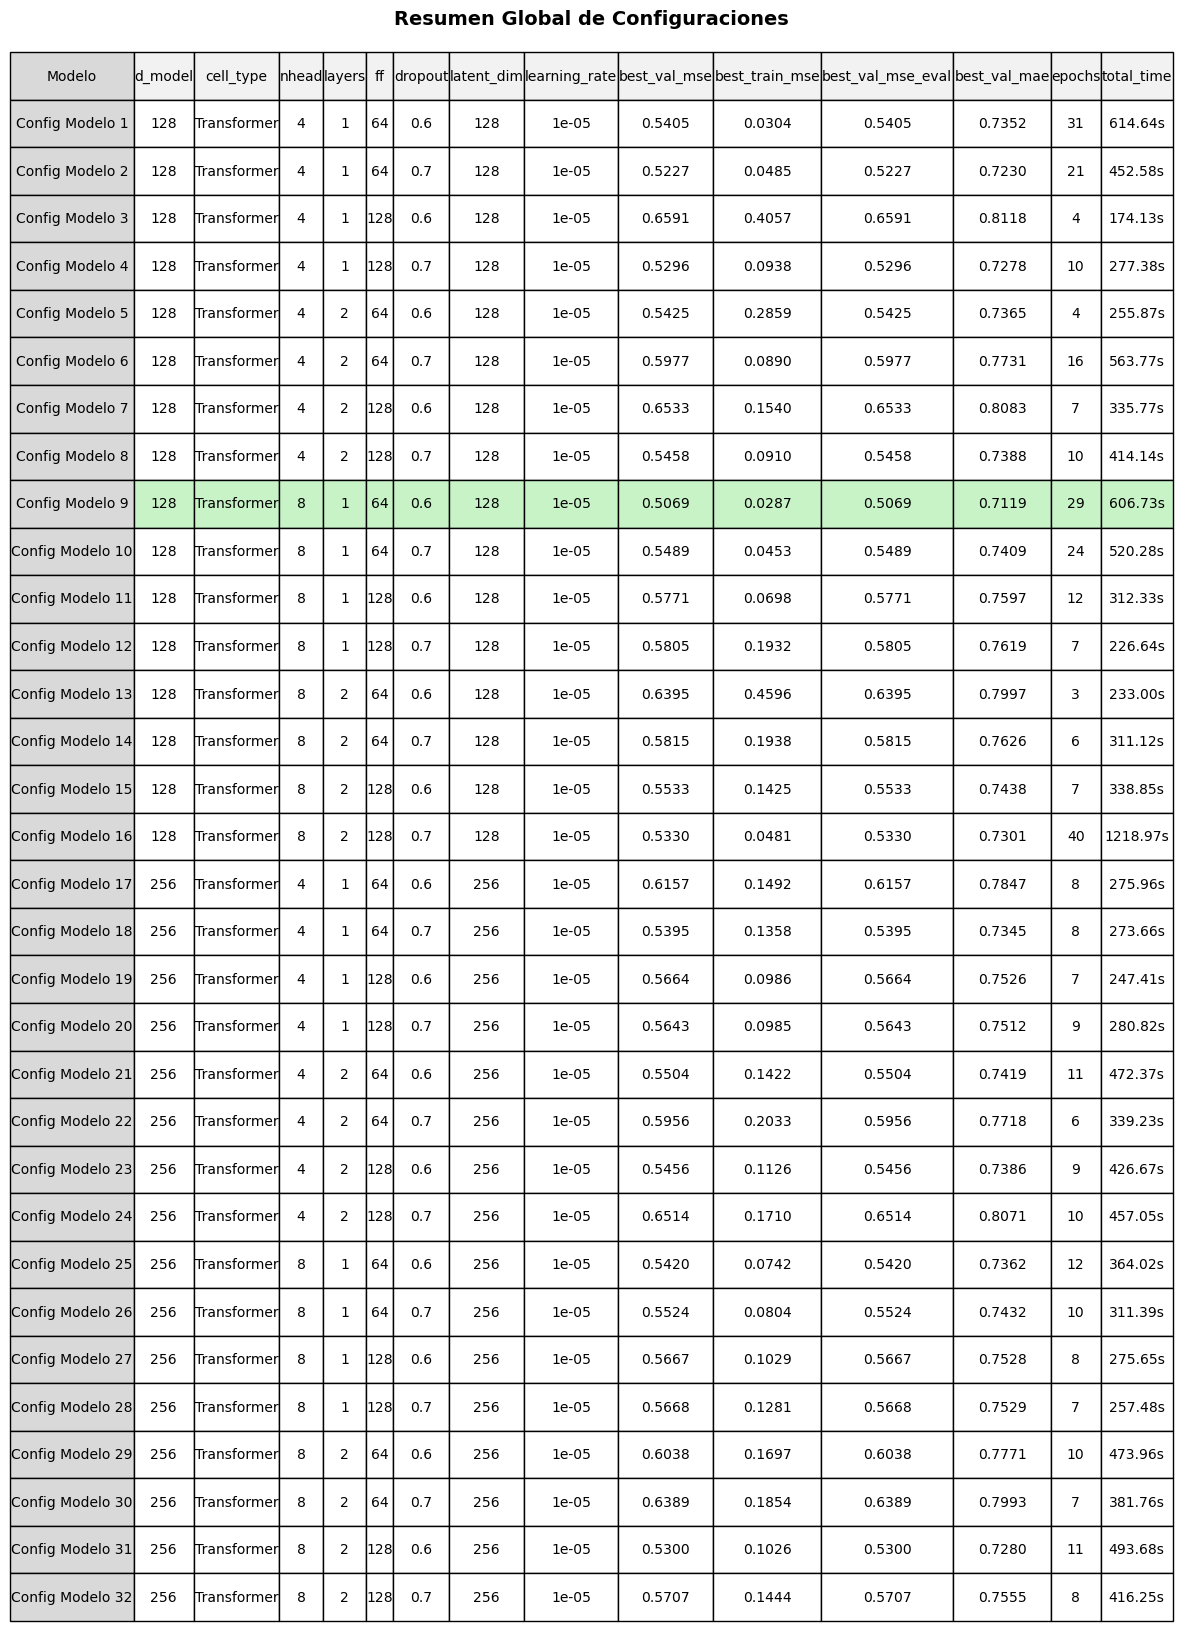

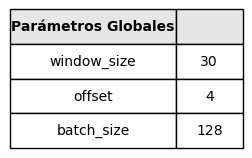

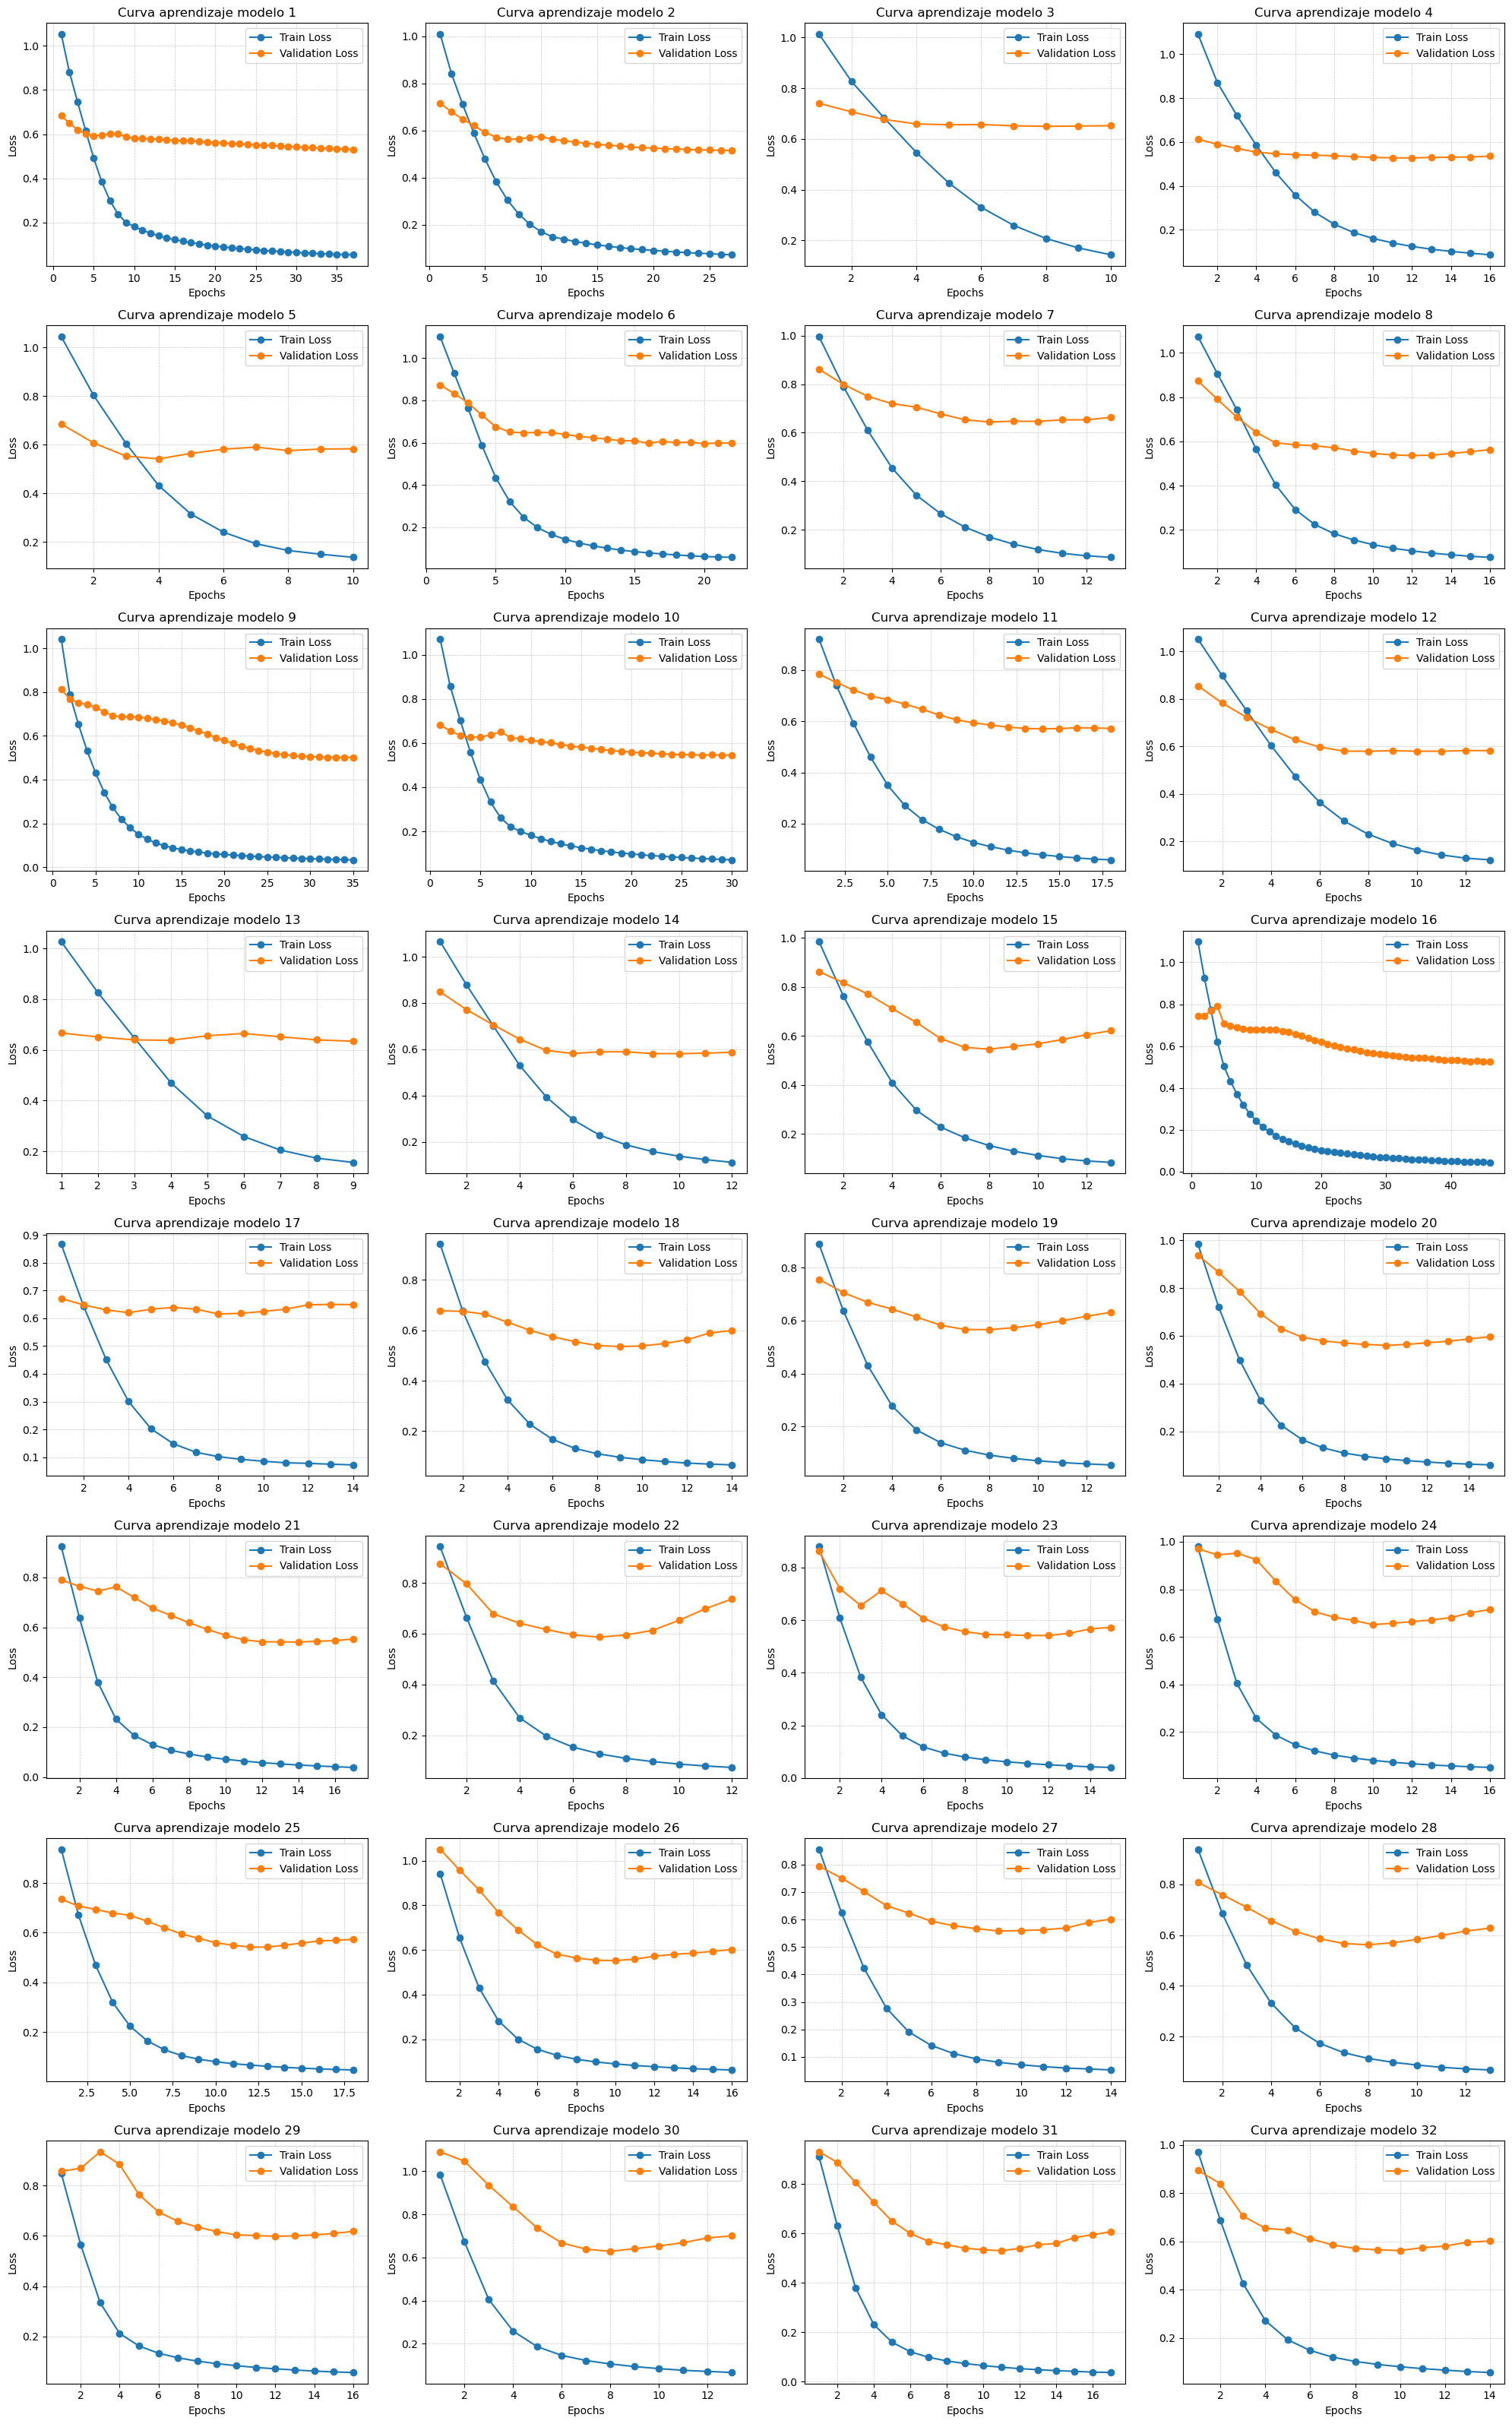

{'d_model': [256],
 'nhead': [4],
 'num_layers': [2],
 'dim_feedforward': [128],
 'dropout': [0.6]}

In [21]:
visualizador = VisualizadorResultadosModelos(data_dict, graphs_per_row=4)
visualizador.pintar_leyenda()
visualizador.pintar_learning_curve()
{'d_model': [256], 'nhead': [4], 'num_layers': [2], 'dim_feedforward': [128], 'dropout': [0.6]}


# Cuál creo que es el mejor modelo

> OJO: Es necesaria la versión de **python > 3.7** ya que a partir de esa versión los diccionarios guardan su posición.

In [22]:
MODELO_ESCOGIDO = 15
MODELO_ESCOGIDO_RENUMERADO = MODELO_ESCOGIDO - 1

# Reentreno el mejor modelo con los mismos parámetros pero ahora train=train+val

In [23]:
# Cargar los datos guardados
data_dict_modelo_seleccionad = joblib.load(FICHERO)

df_result = data_dict_modelo_seleccionad['df_results']
WINDOW_SIZE = data_dict['windows_size']
OFFSET = data_dict['offset']
BATCH_SIZE = data_dict['batch_size']


# Extraer la fila correspondiente al modelo seleccionado como diccionario
modelo_seleccionado = df_result.iloc[MODELO_ESCOGIDO_RENUMERADO].to_dict()

In [24]:

# Construir param_grid automáticamente con los valores del modelo seleccionado
param_grid = {
    "d_model": [modelo_seleccionado["d_model"]],
    "nhead": [modelo_seleccionado["nhead"]],
    "num_layers": [modelo_seleccionado["num_layers"]],
    "dim_feedforward": [modelo_seleccionado["dim_feedforward"]],
    "dropout": [modelo_seleccionado["dropout"]]
}

# Generar combinaciones (aunque aquí solo habrá una, ya que cada valor es una lista de un solo elemento)
param_combinations = list(product(
    param_grid["d_model"],
    param_grid["nhead"],
    param_grid["num_layers"],
    param_grid["dim_feedforward"],
    param_grid["dropout"]
))

print(param_grid)  # Verificar que se ha construido correctamente


{'d_model': [128], 'nhead': [8], 'num_layers': [2], 'dim_feedforward': [128], 'dropout': [0.6]}


In [25]:
best_model, df_results_mejor_modelo = run_grid_search_experiments(
    train_loader=train_loader,
    val_loader=val_loader,
    train_dataset=train_dataset,
    param_combinations=param_combinations,
    device=device
)

Probando: d_model=128, nhead=8, layers=2, ff=128, dropout=0.6
Inicio del entrenamiento usando el dispositivo: cuda
Epoch [1/100] - Train Loss: 1.0160, Train MAE: 0.8248 | Val Loss: 0.7032, Val MAE: 0.7057
Epoch [2/100] - Train Loss: 0.8057, Train MAE: 0.7250 | Val Loss: 0.7079, Val MAE: 0.7000
Epoch 2: Mejora menor a 0.01 (sin mejora significativa).
Epoch [3/100] - Train Loss: 0.6294, Train MAE: 0.6290 | Val Loss: 0.7112, Val MAE: 0.6896
Epoch 3: Mejora menor a 0.01 (sin mejora significativa).
Epoch [4/100] - Train Loss: 0.4669, Train MAE: 0.5298 | Val Loss: 0.7033, Val MAE: 0.6712
Epoch 4: LR cambió de 0.00001000 a 0.00000500
Epoch 4: Mejora menor a 0.01 (sin mejora significativa).
Epoch [5/100] - Train Loss: 0.3639, Train MAE: 0.4659 | Val Loss: 0.6895, Val MAE: 0.6707
Epoch [6/100] - Train Loss: 0.3090, Train MAE: 0.4258 | Val Loss: 0.6794, Val MAE: 0.6685
Epoch [7/100] - Train Loss: 0.2649, Train MAE: 0.3917 | Val Loss: 0.6665, Val MAE: 0.6667
Epoch [8/100] - Train Loss: 0.2308, Tr

# Evaluación y prediccion

In [26]:
criterion = nn.MSELoss()

# 📌 Evaluar en Train y Validation
train_loss = evaluate_model(best_model, train_loader, criterion, device)
val_loss = evaluate_model(best_model, val_loader, criterion, device)

print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# 📌 Hacer Predicciones sobre Test (sin usar las etiquetas)
best_model.eval()
Y_pred = []
with torch.no_grad():
    for X_test, _ in test_loader:  # 🔹 Solo X_test, sin Y_test
        X_test = X_test.to(device)
        Y_pred.append(best_model(X_test).cpu().numpy())

# Convertir las predicciones a un array numpy
Y_pred = np.vstack(Y_pred)

# 📌 Evaluar Test (Solo si tiene etiquetas disponibles)
try:
    test_loss = evaluate_model(best_model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}")
except:
    print("⚠️ No hay etiquetas en Test. Se omite la evaluación.")


Train Loss: 0.0355 | Val Loss: 0.5334
Test Loss: 0.8989


# Guardo predicciones finales

In [27]:
data_dict = {
    "df_results": df_results,
    "predictions_test": Y_pred,
    "windows_size": WINDOW_SIZE,
    "offset": OFFSET,
    "batch_size": BATCH_SIZE
}

# Guardar en un solo archivo
joblib.dump(data_dict, FIC_SALIDA)

['prediccion_transformers.joblib']